In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image, display, Markdown, Math
from scipy.io import loadmat
from scipy.stats import expon


from sklearn.base import BaseEstimator
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

rc = {
    'axes.grid': False,
    'axes.edgecolor': 'lightgrey',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.color': 'grey',
    'xtick.labelsize': 'small',
    'xtick.bottom': True,
    'xtick.major.size': 2.5,
    'ytick.color': 'grey',
    'ytick.major.size': 2.5,
    'ytick.left': True,
}

sns.set(style='whitegrid', rc=rc)

### Programming exercises

In [2]:
def load_mat_data(path, key):
    mat_data = loadmat(path)
    return mat_data[key]


class SimpleLinearRegression():
    
    def fit(self, X, y=None):
        self.w_ = np.linalg.inv(X.T @ X) @ (X.T @ y)
        return self
        
    def predict(self, X):
#         return self.w_.T @ x 
        return X @ self.w_    

    
class RegularizedSimpleLinearRegression(BaseEstimator):
    
    def __init__(self, regularization_param=0):
        self.regularization_param = regularization_param
    
    def fit(self, X, y=None):
        N = X.shape[0]  #  Number of training examples
        X_sq = X.T @ X
        self.w_ = np.linalg.inv(X_sq + (N * self.regularization_param * np.eye(len(X_sq)))) @ (X.T @ y)
        return self
        
    def predict(self, X):
        return X @ self.w_

#### 1.2

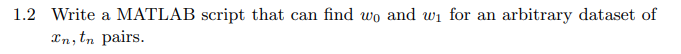

In [3]:
Image('imgs/exercise.1.2.png')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

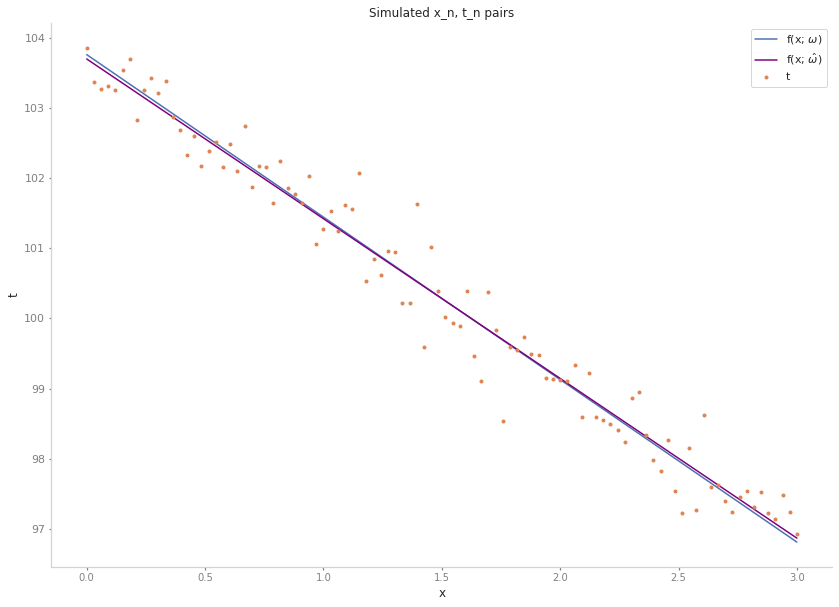

In [4]:
true_w = np.array([103.758, -2.314])
true_f = lambda x: true_w[0] + true_w[1]*x

x = np.linspace(0, 3, 100)[:, np.newaxis]
y = true_f(x)

rng = np.random.RandomState(42)
noise = np.random.standard_normal(size=y.shape[0]) / 2.5

X = np.column_stack((np.ones_like(x), x))
t = y + noise[:, np.newaxis]

lin_reg = SimpleLinearRegression()
lin_reg.fit(X, t)

display(Math(f'\omega = {true_w}'))
display(Math(f'\hat \omega = {np.ravel(lin_reg.w_)}'))

plt.figure(figsize=(14,10))
plt.plot(x, y, '-', label='f(x; $\omega$)')
plt.plot(x, lin_reg.predict(X), '-', label='f(x; $\hat \omega$)', c='purple')
plt.plot(x, t, 'o', label='t', markersize=3)
plt.title('Simulated x_n, t_n pairs')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()
plt.show()

#### 1.6

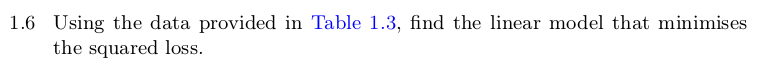

In [5]:
Image('imgs/exercise.1.6.png')

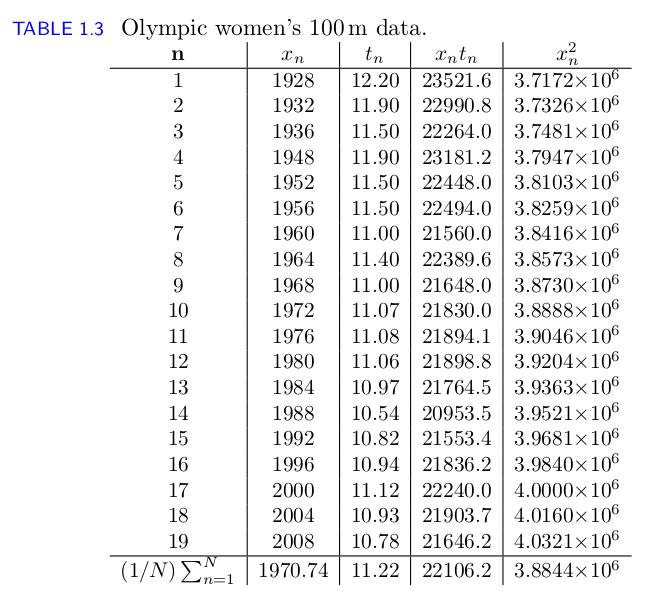

In [6]:
Image('imgs/table.1.3.png')

In [7]:
olympic100female = load_mat_data('data/olympics.mat', 'female100')
x = olympic100female[:, 0, np.newaxis]
y = olympic100female[:, 1, np.newaxis]

X = np.column_stack((np.ones_like(x), x))

lin_reg = SimpleLinearRegression()
lin_reg.fit(X,y)


display(Math(f'\hat \omega = {lin_reg.w_.ravel()}'))

<IPython.core.display.Math object>

#### 1.7

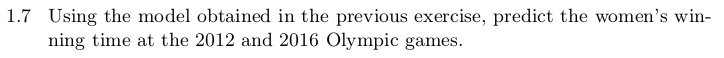

In [8]:
Image('imgs/exercise.1.7.png')

In [9]:
x_new = np.array([2012, 2016])[:, np.newaxis]
X_new = np.column_stack((np.ones_like(x_new), x_new))

print(f'Predicted times for {x_new.ravel()}: {lin_reg.predict(X_new).ravel()}')

Predicted times for [2012 2016]: [10.59966838 10.53938113]


#### Exercise 1.8

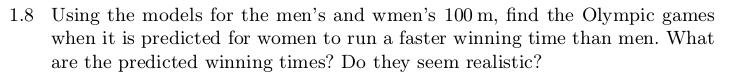

In [10]:
Image('imgs/exercise.1.8.png')

In [11]:
olympic100male = load_mat_data('data/olympics.mat', 'male100')
olympic100female = load_mat_data('data/olympics.mat', 'female100')

X_men = np.column_stack((np.ones_like(olympic100male[:, 0]), olympic100male[:, 0]))
X_women = np.column_stack((np.ones_like(olympic100female[:, 0]), olympic100female[:, 0]))

y_men = olympic100male[:, 1, np.newaxis]
y_women = olympic100female[:, 1, np.newaxis]

lin_reg_men = SimpleLinearRegression().fit(X_men, y_men)
lin_reg_women = SimpleLinearRegression().fit(X_women, y_women)

years = np.arange(2012, 3012, step=4)[:, np.newaxis]
X_new = np.hstack((np.ones_like(years), years))

y_hat_men = lin_reg_men.predict(X_new).ravel()
y_hat_women = lin_reg_women.predict(X_new).ravel()

year_when_faster = years[y_hat_women < y_hat_men][0]
X_year_when_faster = np.hstack((1, year_when_faster))
print(f'First olympic year for women to outrun men: {year_when_faster}')
print(f'{year_when_faster} winning time for men {lin_reg_men.predict(X_year_when_faster)}')
print(f'{year_when_faster} winning time for women {lin_reg_women.predict(X_year_when_faster)}')

First olympic year for women to outrun men: [2592]
[2592] winning time for men [1.86280014]
[2592] winning time for women [1.85801728]


#### Exercise 1.12

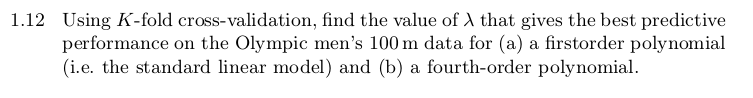

In [12]:
Image('imgs/exercise.1.12.png')

In [13]:
x = load_mat_data('data/olympics.mat', 'male100')

X = x[:, 0, np.newaxis]
y = x[:, 1, np.newaxis]

poly_order_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('regularized_lin_reg', RegularizedSimpleLinearRegression())
])

param_distributions = {
    'poly_features__degree': np.arange(0, 6) + 1,
    'regularized_lin_reg__regularization_param': expon(scale=1e-3)
} 

random_search = RandomizedSearchCV(poly_order_pipeline, 
                                   param_distributions=param_distributions, n_iter=6*(10**4),
                                   scoring='neg_mean_squared_error', n_jobs=-1, 
                                   cv=len(X), verbose=4, random_state=42, 
                                   return_train_score=True)

random_search.fit(X, y)

Fitting 27 folds for each of 60000 candidates, totalling 1620000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 6656 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 38144 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 81920 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 138496 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 207360 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 289024 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 382976 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 489728 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 608768 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 740608 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 884736 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1041664 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1210880 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1

RandomizedSearchCV(cv=27, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('poly_features',
                                              PolynomialFeatures(degree=2,
                                                                 include_bias=True,
                                                                 interaction_only=False,
                                                                 order='C')),
                                             ('regularized_lin_reg',
                                              RegularizedSimpleLinearRegression(regularization_param=0))],
                                      verbose=False),
                   iid='deprecated', n_iter=60000, n_jobs=-1,
                   param_distributions={'poly_features__degree': array([1, 2, 3, 4, 5, 6]),
                                        'regularized_lin_reg__regularization_param': <scipy.stats._distn_infrastructure.rv_frozen obj

In [14]:
random_search.best_params_

{'poly_features__degree': 5,
 'regularized_lin_reg__regularization_param': 1.6538550065267005e-06}

In [15]:
random_search.best_score_

-0.047953556968250446

In [16]:
cv_results = pd.DataFrame(random_search.cv_results_, 
                          columns=['param_poly_features__degree', 
                                   'param_regularized_lin_reg__regularization_param',
                                   'mean_train_score', 'mean_test_score'])

cv_results.info()
cv_results.sort_values('mean_test_score', ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 4 columns):
param_poly_features__degree                        60000 non-null object
param_regularized_lin_reg__regularization_param    60000 non-null object
mean_train_score                                   60000 non-null float64
mean_test_score                                    60000 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.8+ MB


,param_poly_features__degree,param_regularized_lin_reg__regularization_param,mean_train_score,mean_test_score
14008,5,1.65386e-06,-0.033102,-0.047954
11798,5,3.36804e-06,-0.032258,-0.048982
32899,5,1.34044e-06,-0.043854,-0.049008
35610,5,1.20068e-05,-0.029771,-0.050232
52508,5,6.90709e-06,-0.029932,-0.050326
40722,5,5.39091e-06,-0.030551,-0.050522
10808,5,4.36269e-06,-0.030557,-0.050736
9415,5,3.37864e-06,-0.033344,-0.050873
17395,5,8.10586e-06,-0.029953,-0.051036
14928,5,6.08912e-06,-0.030272,-0.051145


In [17]:
cv_results.rename(columns={
    'param_regularized_lin_reg__regularization_param':'lambda',
    'param_poly_features__degree': 'polynomial_degree'    
}, inplace=True)

cv_results['polynomial_degree'] = cv_results['polynomial_degree'].astype(np.int16)
cv_results['lambda'] = cv_results['lambda'].astype(np.float64)

cv_results.sort_values('mean_test_score', ascending=False).head(20)

,polynomial_degree,lambda,mean_train_score,mean_test_score
14008,5,0.000002,-0.033102,-0.047954
11798,5,0.000003,-0.032258,-0.048982
32899,5,0.000001,-0.043854,-0.049008
35610,5,0.000012,-0.029771,-0.050232
52508,5,0.000007,-0.029932,-0.050326
40722,5,0.000005,-0.030551,-0.050522
10808,5,0.000004,-0.030557,-0.050736
9415,5,0.000003,-0.033344,-0.050873
17395,5,0.000008,-0.029953,-0.051036
14928,5,0.000006,-0.030272,-0.051145


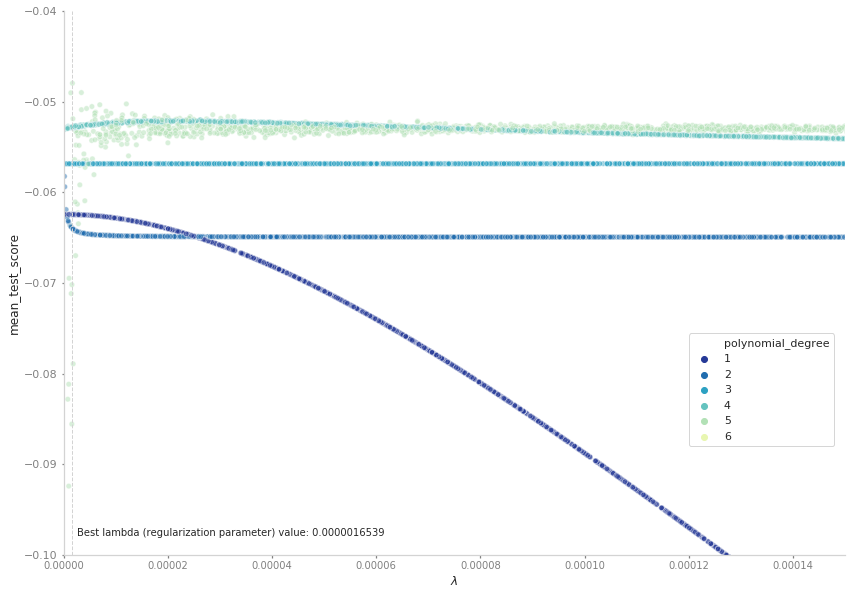

In [18]:
best_lambda = random_search.best_params_['regularized_lin_reg__regularization_param']

plt.figure(figsize=(14,10))
sns.scatterplot(x='lambda', y='mean_test_score', hue='polynomial_degree', data=cv_results, 
                alpha=0.5, s=30, palette=sns.color_palette('YlGnBu_r', 6))
plt.xlim([0, 0.00015])
plt.ylim([-0.1, -0.04])
plt.axvline(best_lambda, linestyle='--', c='lightgrey', lw=1)
plt.annotate('Best lambda (regularization parameter) value: {:.10f}'.format(best_lambda), 
             xy=(0.09, 0.1), xycoords='figure fraction', fontsize='small')
plt.legend(loc=(0.8, 0.2))
plt.xlabel('$\lambda$')
plt.show()

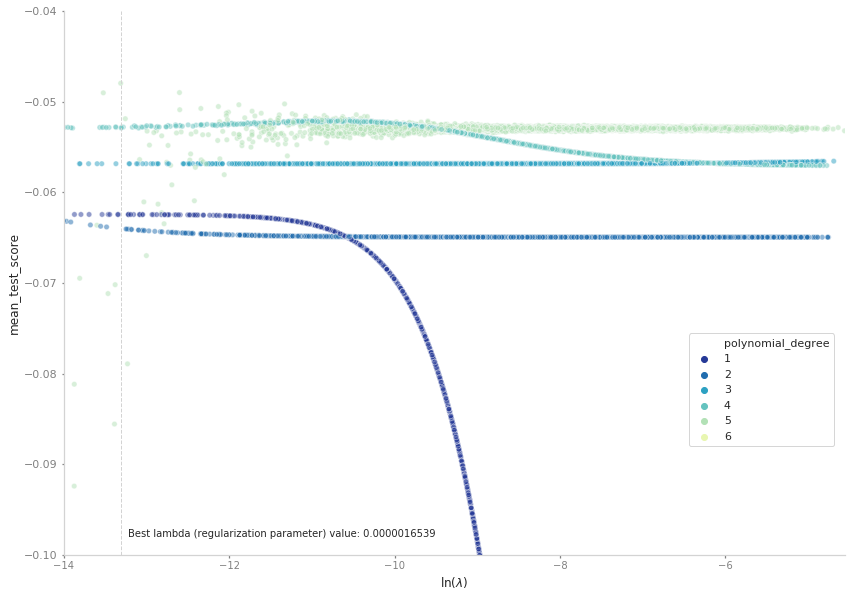

In [21]:
plt.figure(figsize=(14,10))
palette = sns.color_palette('YlGnBu_r', 6)

log_lambda = np.log(cv_results['lambda'])

sns.scatterplot(x=log_lambda, y='mean_test_score', 
                hue='polynomial_degree', data=cv_results, 
                alpha=0.5, s=30, 
                palette=palette)

plt.xlim([-14, np.max(log_lambda)])
plt.ylim([-0.1, -0.04])

plt.axvline(np.log(best_lambda), linestyle='--', c='lightgrey', lw=1)
plt.annotate('Best lambda (regularization parameter) value: {:.10f}'.format(best_lambda), 
             xy=(0.15, 0.1), xycoords='figure fraction', fontsize='small')

plt.legend(loc=(0.8, 0.2))
plt.xlabel('$\ln (\lambda)$')

plt.show()

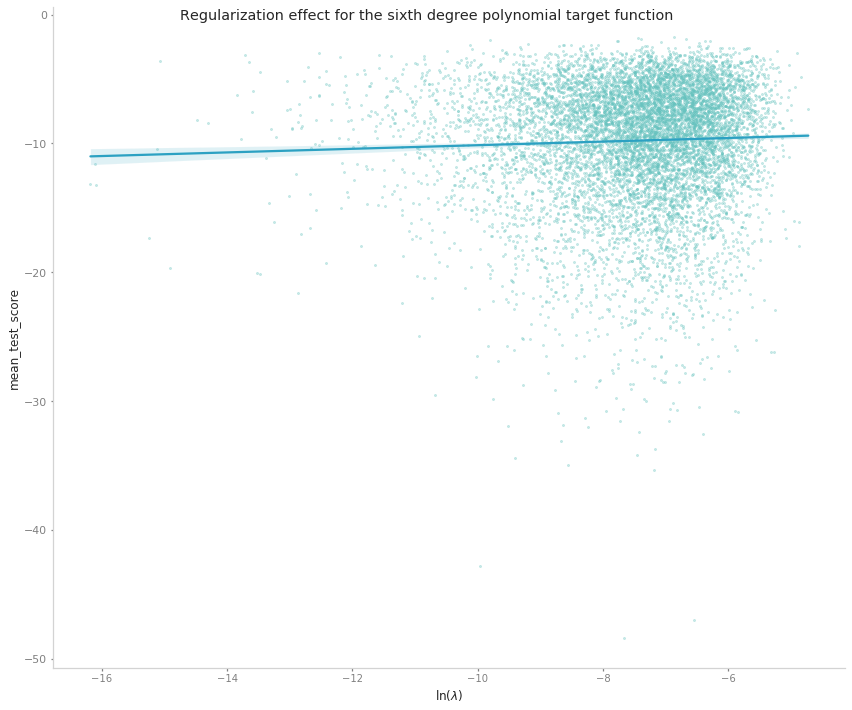

In [22]:
nth_degree = lambda n: cv_results['polynomial_degree'] == n

sixth_order = cv_results[nth_degree(6)].copy()
sixth_order['log_lambda'] = sixth_order['lambda'].apply(np.log)

g = sns.lmplot(x='log_lambda', y='mean_test_score', 
               data=sixth_order, height=10, aspect=1.2,
               scatter_kws=dict(color=palette[-3], alpha=0.3, s=4),
               line_kws=dict(color=palette[-4]))
g = g.set_xlabels('$\ln (\lambda)$')
g = g.fig.suptitle('Regularization effect for the sixth degree polynomial target function')